In [23]:
import torch
from torch.nn.functional import conv1d, pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
def objective_torch(a, b, vandermonde, fvals):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    a : torch.Tensor
        Coefficient of the first polynomial.
    b : torch.Tensor
        Coefficient of the second polynomial.
    vandermonde : torch.Tensor
        The vandermonde matrix of the data points.
    fvals : torch.Tensor
        The f values of the data points.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    a.requires_grad = True
    b.requires_grad = True

    # Compute loss using squared distance function
    complementary = torch.norm(FFTConvolve("full").forward(a, torch.flip(a, dims=[0])) - FFTConvolve("full").forward(b, torch.flip(b, dims=[0])))**2
    fit = torch.norm(vandermonde @ a - fvals)**2
    loss = complementary + fit
    return loss


# Set up optimizer
N = 16  # degree of polynomial
initial_a = torch.randn(N, device=device, requires_grad=True)
initial_b = torch.randn(N, device=device, requires_grad=True)
initial_a = (initial_a / torch.norm(initial_a)).clone().detach().requires_grad_(True)
initial_b = (initial_b / torch.norm(initial_b)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial_a, initial_b], max_iter=2000)

# Set test function
f = lambda x: 1 / (10*x)
xvals = np.linspace(0.1, 1, 100)
fvals = torch.tensor(f(xvals), dtype=torch.float32, device=device)
vandermonde = torch.tensor(np.vander(xvals, len(initial_a), increasing=True), dtype=torch.float32, device=device)


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial_a, initial_b, vandermonde, fvals)
    loss.backward()
    return loss

# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

In [48]:
# Print the results of the optimization
print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 16
Time: 16.017990112304688
Final: 0.01797250658273697
# Iterations: 1506
-----------------------------------------------------


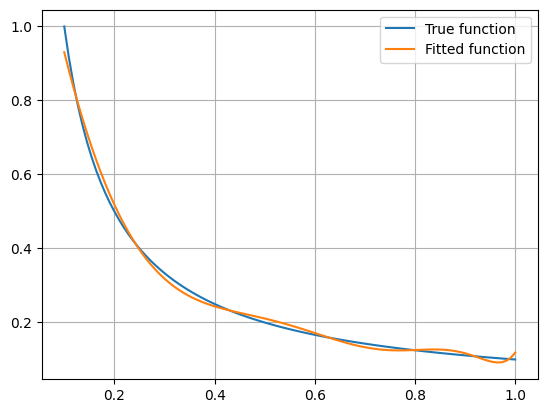

In [49]:
avals = vandermonde.detach().numpy() @ initial_a.detach().numpy()
bvals = vandermonde.detach().numpy() @ initial_b.detach().numpy()

plt.plot(xvals, f(xvals), label='True function')
plt.plot(xvals, avals, label='Fitted function')
plt.legend()
plt.grid()
plt.show()

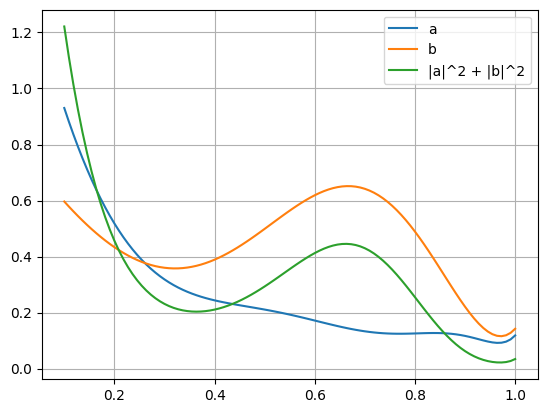

In [50]:
plt.plot(xvals, avals, label='a')
plt.plot(xvals, bvals, label='b')
plt.plot(xvals, np.abs(avals)**2 + np.abs(bvals)**2, label='|a|^2 + |b|^2')
plt.legend()
plt.grid()
plt.show()

In [14]:
def objective_torch(x, P):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    x : torch.Tensor
        The input tensor for which the loss is computed.
    P : torch.Tensor
        The target tensor to compare against.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    x.requires_grad = True

    # Compute loss using squared distance function
    loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
    return loss


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial, conv_p_negative)
    loss.backward()
    return loss


# Set the size of the polynomial
N = 16

# Generate a random polynomial of size N on the specified device
poly = torch.randn(N, device=device)

# Define the granularity for padding
granularity = 2 ** 25

# Pad the polynomial to match the granularity
P = pad(poly, (0, granularity - poly.shape[0]))

# Compute the FFT of the padded polynomial
ft = fft(P)

# Normalize the polynomial using the maximum norm of its FFT
P_norms = ft.abs()
poly /= torch.max(P_norms)

# Compute the negative convolution of the polynomial with its flipped version
conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0])) * -1

# Adjust the last element to ensure the norm condition
conv_p_negative[poly.shape[0] - 1] = 1 - torch.norm(poly) ** 2

# Set up optimizer
initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial], max_iter=1000)

# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

# Print the results of the optimization
print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 16
Time: 0.6851620674133301
Final: 5.608651321153957e-10
# Iterations: 131
-----------------------------------------------------


In [10]:
def objective_torch(x, P):
    x.requires_grad = True

    # Compute loss using squared distance function
    loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
    return loss

times = []
final_vals = []
num_iterations = []

for k in range(4, 20):
    N = 2 ** k
    poly = torch.randn(N, device=device)

    granularity = 2 ** 25
    P = pad(poly, (0, granularity - poly.shape[0]))
    ft = fft(P)

    # Normalize P
    P_norms = ft.abs()
    poly /= torch.max(P_norms)

    conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0]))* -1
    conv_p_negative[poly.shape[0] - 1] = 1 - torch.norm(poly) ** 2

    # Initializing Q randomly to start with
    initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
    initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)

    optimizer = torch.optim.LBFGS([initial], max_iter=1000)

    t0 = time.time()

    def closure():
        optimizer.zero_grad()
        loss = objective_torch(initial, conv_p_negative)
        loss.backward()
        return loss

    optimizer.step(closure)

    t1 = time.time()

    total = t1-t0
    times.append(total)
    final_vals.append(closure().item())
    num_iterations.append(optimizer.state[optimizer._params[0]]['n_iter'])
    print(f'N: {N}')
    print(f'Time: {total}')
    print(f'Final: {closure().item()}')
    print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
    print("-----------------------------------------------------")

print(times)
print(final_vals)
print(num_iterations)

N: 16
Time: 0.8362300395965576
Final: 6.212476089118013e-10
# Iterations: 78
-----------------------------------------------------
N: 32
Time: 1.9712750911712646
Final: 4.43686212747707e-06
# Iterations: 360
-----------------------------------------------------
N: 64
Time: 1.5400800704956055
Final: 6.780034595976758e-07
# Iterations: 302
-----------------------------------------------------
N: 128
Time: 2.8109209537506104
Final: 1.3475355444825254e-05
# Iterations: 483
-----------------------------------------------------
N: 256
Time: 6.483417987823486
Final: 1.036808953358559e-06
# Iterations: 1000
-----------------------------------------------------
N: 512
Time: 4.48820686340332
Final: 1.8909720438387012e-06
# Iterations: 816
-----------------------------------------------------
N: 1024
Time: 7.285927057266235
Final: 1.737327579576231e-06
# Iterations: 936
-----------------------------------------------------
N: 2048
Time: 6.603424787521362
Final: 2.289321628268226e-06
# Iterations:

KeyboardInterrupt: 